In [1]:
#2D simulation of a wave propagating through inhomogeneous medium
import cmath
import numpy as np
import matplotlib.pyplot as plt
from fun_propagate import fun_propagate
from scan import scan
from grating1D import grating1D
from input_wavefront import input_wavefront
from scan_conjugate_correction import scan_conjugate_correction
from calculate_conjugated_mask import calculate_conjugated_mask

In [2]:
#user parameters
m =2
n =1
N=np.array([int(512/m), int(1024/n)]) # size of grid z,x
u=np.array([.2*m, .1*n]) #units z, x in lambda
NA=0.5 #NA of lens
RI=np.array([1.33, 1.4]) #refractive indices of turbid sample (we assume a binary RI-distribution for simplicity)

In [3]:
#creating real-space grid
x=np.arange(-N[1]/2,N[1]/2)*u[1]  #simulation window shows +/- 5 wavelengths in x
z=np.arange(0,N[0])*u[0]  #simulation window shows ~5 wavelengths in z
[X,Z]=np.meshgrid(x,z)

#creating k-space grid
uk=2*np.pi/u/N   #increment in frequency-space is 1/(size of grid in x-space); increment in k-space is 2*pi/(size of grid in x-space)
kx=np.arange(-N[1]/2,N[1]/2)*uk[1] 
kz=np.arange(0,N[0])*uk[0]
[Kx,Kz]=np.meshgrid(kx,kz)

(0, 200)

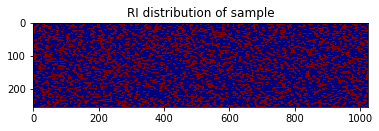

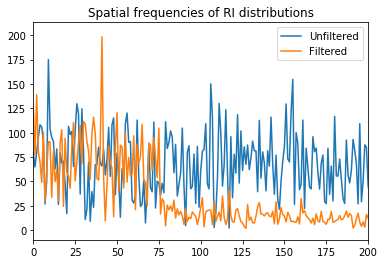

In [4]:
#defining random sample

tmp=np.random.random(N) #array of random numbers with dimensions of N

#low-pass filtering of random sample (performed in k-space)

F_tmp=np.fft.fft2(tmp)  #fourier transform random array
sigma=N*u/10 # 10% of simulation region ~ 10x10 wavelengths in real space, 
sigma1 = int(N[0]*u[0]/10)
F_filter=np.exp(-X**2/(sigma[1]*n)**2-(Z-N[0]*u[0]/2)**2/(sigma[0]*m)**2) #Gaussian LP filter function
F_filter1=np.sqrt((X/n)**2+(Z-N[0]*u[0]/2)**2/(m)**2)<sigma1^2  #hard cutoff LP filter
tmp2=np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(F_filter1*F_tmp))) #apply filter, undo shift to center spectrum on zero in k space
                                                                    #2d fft back to lambda space and shift center back to zero
sample=np.fft.ifftshift((tmp2/np.max(tmp2)>0.1)*(RI[1]-RI[0])+RI[0], 1) #undo shift to center on zero for X axis, and threshold normalized values to >0.1
plt.figure(0)
plt.imshow(np.real(sample),cmap='jet')   #Plot real part of filtered random refractive indices
plt.title('RI distribution of sample')

plt.figure(1)  #check spatial frequency distribution after filtering
test = np.fft.fft2(sample)
plt.plot(np.real(abs(F_tmp[1]/2)), label = 'Unfiltered')
plt.plot(np.real(abs(test[1])), label = 'Filtered')
plt.title('Spatial frequencies of RI distributions')
plt.legend()
plt.xlim([0,200])

In [33]:
E_in, phase, amp = input_wavefront(NA, N, u)

Text(0.5,0,'x')

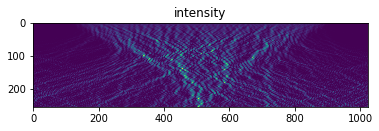

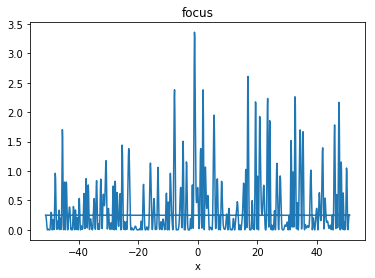

In [6]:
#now we propagate through the turbid sample 

E=fun_propagate(u, E_in,sample)   #execute propagation 
    
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E)**2,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.real(E[-1,:])**2))
plt.title('focus')
plt.xlabel('x')

Text(0.5,0,'x')

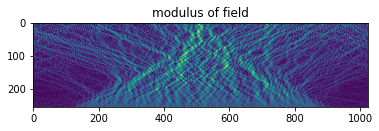

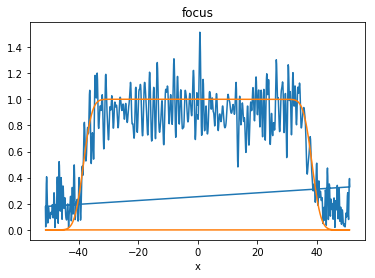

In [7]:
#test: propagating the scrambled focus backwards through the aberrating sample
#we should see that the aberration-free wavefront is (almost) restored

E2=fun_propagate(u,np.conj(E[-1,:]),np.flip(sample,0)) 
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E2)**1,1))
plt.title("modulus of field")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.abs(E2[-1,:])))
plt.plot(np.fft.fftshift(x),(np.abs(E_in)))
plt.title('focus')
plt.xlabel('x')

Text(0.5,1,'intensity')

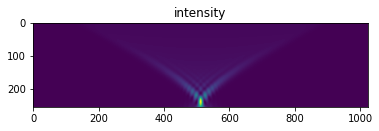

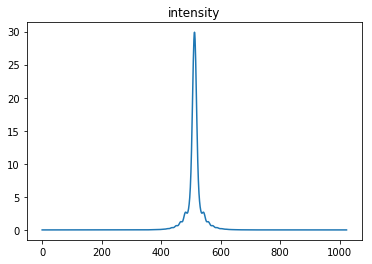

In [8]:
#now we propagate through a clear sample in order to get an undistored focus
#RI_avg=np.mean(sample)
sample_clear=np.ones(sample.shape)*1.33
E_gs=fun_propagate(u,E_in,sample_clear)  #gs for "guidestar"

plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E_gs)**2,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(abs(E_gs[-1,:])**2))
plt.title("intensity")


Text(0.5,0,'x')

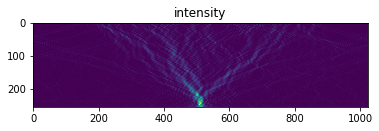

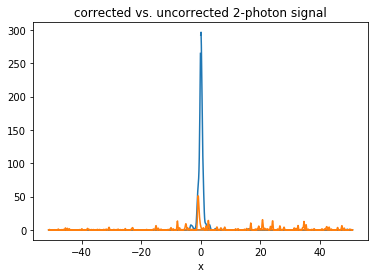

In [9]:
#now we propagate the "guidestar" through the turbid sample

E3=fun_propagate(u,np.conj(E_gs[-1,:]),np.flip(sample,0))
E_corr=np.conj(E3[-1,:]) #this is our correction field for the central imaging point

E_test=fun_propagate(u,abs(E_in)*E_corr/abs(E_corr),sample) #we can only correct the phase
#E_test=fun_propagate(u, E_corr,sample)
E_test2=fun_propagate(u, E_in,sample)

plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E_test)**2,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),np.abs(E_test[-1,:])**4)
plt.plot(np.fft.fftshift(x),np.abs(E_test2[-1,:])**4)
plt.title('corrected vs. uncorrected 2-photon signal')
plt.xlabel('x')

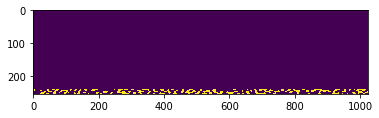

In [11]:
sample_slice = np.ones(sample.shape)*1.33
sample_slice[240:256,:] = sample[240:256,:]
plt.imshow(sample_slice)

In [12]:
#set FOV in pixels
FOV_in = 100
#set image step size in pixels
image_step_size = 1
#set grating spacing in pixels
grating_space = 20
#conjugated correction plane (in grid units, i.e. out of 256)
z_corr = 250
#number of points for conjugated correction
correction_step_size = 1

In [13]:
#calculate conjugated correction mask for turbid sample
E_conj_corr = calculate_conjugated_mask(u, z_corr, sample, FOV_in, correction_step_size)
#calculate conjugated correction mask for clear sample
E_conj_corr_clear = calculate_conjugated_mask(u, z_corr, sample_clear, FOV_in, correction_step_size)
#calculate conjugated correction mask for conj. sample with one line of inhomogeneity
E_conj_corr_slice = calculate_conjugated_mask(u, z_corr, sample_slice, FOV_in, correction_step_size)

In [14]:
#focusing through a clear sample
image_clear=scan(u,E_in, sample_clear, grating_space, image_step_size, FOV_in)
pupil_corr_clear=scan(u,abs(E_in)*E_corr/abs(E_corr), sample_clear, grating_space, image_step_size, FOV_in)
conjugate_corr_clear= scan_conjugate_correction(u, sample_clear, E_conj_corr_clear, z_corr, grating_space, image_step_size, FOV_in)

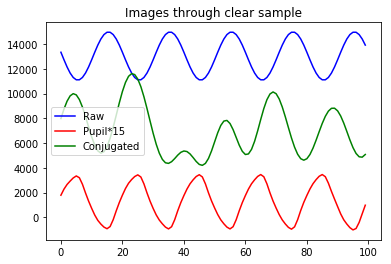

In [15]:
fig, ax = plt.subplots()
ax.plot(image_clear+7000, 'b', label = 'Raw')
ax.plot(pupil_corr_clear*20-7000, 'r', label = 'Pupil*20')
ax.plot(conjugate_corr_clear,'green', label = 'Conjugated')
plt.title('Images through clear sample')
plt.legend()

In [16]:
#focusing through the scattering sample
image_scatt=scan(u,E_in, sample, grating_space, image_step_size, FOV_in)
pupil_corr_scatt=scan(u,abs(E_in)*E_corr/abs(E_corr), sample, grating_space, image_step_size, FOV_in)
conjugate_corr_scatt = scan_conjugate_correction(u,sample,E_conj_corr,z_corr,grating_space,image_step_size,FOV_in)

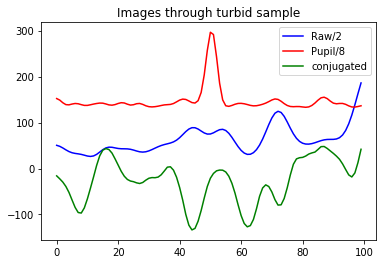

In [37]:
fig, ax = plt.subplots()
ax.plot(image_scatt/4-100, 'b', label = 'Raw/2')
ax.plot(pupil_corr_scatt/8+100, 'r', label = 'Pupil/8')
ax.plot(conjugate_corr_scatt-600,'green', label = 'conjugated')
plt.title('Images through turbid sample')
plt.legend()

In [18]:
#calculate conjugated correction mask for conj. sample with one line of inhomogeneity
E_conj_corr_slice = calculate_conjugated_mask(u, z_corr, sample_slice, FOV_in, correction_step_size)
conjugate_corr_slice = scan_conjugate_correction(u, sample_slice, E_conj_corr_clear, z_corr, grating_space, image_step_size, FOV_in)
image_slice=scan(u,E_in, sample_slice, grating_space, image_step_size, FOV_in)
pupil_corr_slice=scan(u,abs(E_in)*E_corr/abs(E_corr), sample_slice, grating_space, image_step_size, FOV_in)

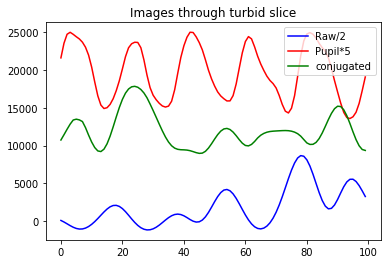

In [32]:
fig, ax = plt.subplots()
ax.plot(image_slice-5000, 'b', label = 'Raw/2')
ax.plot(pupil_corr_slice*50-2000, 'r', label = 'Pupil*5')
ax.plot(conjugate_corr_slice+4000,'green', label = 'conjugated')
plt.title('Images through turbid slice')
plt.legend()